<a href="https://colab.research.google.com/github/11sujan/sujan-ghorasaine-23246201-weatherwise/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [26]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install hands-on-ai
!pip install pyinputplus


In [27]:
import os

os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
os.environ['HANDS_ON_AI_API_KEY'] = input('Enter your API key: ')

KeyboardInterrupt: Interrupted by user

## 📦 Setup and Configuration
Import required packages and setup environment.

In [48]:



import os
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pyinputplus as pyip
from datetime import datetime, timedelta
import json
import re

# Weather API
try:
    from fetch_my_weather import get_weather
    WEATHER_AVAILABLE = True
except ImportError:
    WEATHER_AVAILABLE = False
    print("fetch-my-weather not available, using mock data")

plt.style.use('seaborn-v0_8' if hasattr(plt.style, 'available') and 'seaborn-v0_8' in plt.style.available else 'default')
plt.rcParams['figure.figsize'] = (10, 6)


## 🌤️ Weather Data Functions

In [50]:
def get_weather_data(location, forecast_days=5):
    """
    Retrieve weather data for a specified location.
    Handles both real API and mock fallback.
    Returns a weather object or dict.
    """
    try:
        if WEATHER_AVAILABLE:
            data = get_weather(location=location, format='json')
            return data
        else:
            raise ValueError("Weather API not available")
    except Exception as e:
        print(f"Error retrieving weather for '{location}': {e}")
        return None


## 📊 Visualisation Functions

In [49]:
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Plot temperature forecast for provided weather_data.
    Handles both fetch-my-weather and mock object styles.
    """
    try:
        # Try to use .weather attribute (for fetch-my-weather)
        if hasattr(weather_data, "weather"):
            forecast = weather_data.weather
            dates = [datetime.strptime(day.date, "%Y-%m-%d") for day in forecast]
            temps = [float(day.avgtempC) for day in forecast]
        elif "forecast" in weather_data:
            forecast = weather_data["forecast"]
            dates = [datetime.fromisoformat(day["dt"]) for day in forecast]
            temps = [day["temperature"] for day in forecast]
        else:
            print("No forecast data to visualize.")
            return

        fig, ax = plt.subplots()
        ax.plot(dates, temps, marker='o')
        ax.set_title("Temperature Forecast")
        ax.set_xlabel("Date")
        ax.set_ylabel("Temperature (°C)")
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=45)
        plt.tight_layout()
        if output_type == 'figure':
            return fig
        plt.show()

    except Exception as e:
        print(f"Error in temperature visualisation: {e}")

In [59]:
def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Plot precipitation forecast for provided weather_data.
    Handles both fetch-my-weather and mock object styles.
    """
    try:
        if hasattr(weather_data, "weather"):
            forecast = weather_data.weather
            dates = [datetime.strptime(day.date, "%Y-%m-%d") for day in forecast]
            precips = [float(day.hourly[0].precipMM) for day in forecast]
        elif "forecast" in weather_data:
            forecast = weather_data["forecast"]
            dates = [datetime.fromisoformat(day["dt"]) for day in forecast]
            precips = [day["precipitation"] for day in forecast]
        else:
            print("No forecast data to visualize.")
            return

        fig, ax = plt.subplots()
        ax.bar(dates, precips, color='blue')
        ax.set_title("Precipitation Forecast")
        ax.set_xlabel("Date")
        ax.set_ylabel("Precipitation (mm)")
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=45)
        plt.tight_layout()
        if output_type == 'figure':
            return fig
        plt.show()
    except Exception as e:
        print(f"Error in precipitation visualisation: {e}")

## 🤖 Natural Language Processing

In [58]:
def parse_weather_question(question):
    """
    Parse user question for weather attributes.
    Recognizes temperature, rain, conditions, humidity, wind.
    """
    location = re.findall(r'in ([A-Za-z ]+)', question)
    location = location[0].strip() if location else 'Perth'
    time_period = 'today'
    attribute = 'temperature'
    if any(word in question.lower() for word in ['rain', 'precipitation']):
        attribute = 'precipitation'
    elif 'humidity' in question.lower():
        attribute = 'humidity'
    elif 'wind' in question.lower():
        attribute = 'wind'
    if 'tomorrow' in question.lower():
        time_period = 'tomorrow'
    elif 'weekend' in question.lower():
        time_period = 'weekend'
    elif any(day in question.lower() for day in ['monday','tuesday','wednesday','thursday','friday','saturday','sunday']):
        time_period = next(day for day in ['monday','tuesday','wednesday','thursday','friday','saturday','sunday'] if day in question.lower())
    return {
        "location": location,
        "time_period": time_period,
        "attribute": attribute
    }


def generate_weather_response(parsed_question, weather_data):
    """
    Generate a conversational weather response based on parsed_question.
    """
    loc = parsed_question.get('location', 'location')
    attr = parsed_question.get('attribute', 'temperature')
    period = parsed_question.get('time_period', 'today')
    try:
        if hasattr(weather_data, "weather"):
            forecast = weather_data.weather
            idx = 1 if period == 'tomorrow' and len(forecast) > 1 else (5 if period == 'weekend' and len(forecast) > 5 else 0)
            f = forecast[idx]
            if attr == 'temperature':
                return f"Expected temperature in {loc} is {f.avgtempC}°C."
            elif attr == 'precipitation':
                return f"Expected precipitation in {loc} is {f.hourly[0].precipMM}mm."
            elif attr == 'humidity':
                return f"Expected humidity in {loc} is {f.hourly[0].humidity}%."
            elif attr == 'wind':
                return f"Expected windspeed in {loc} is {f.hourly[0].windspeedKmph} km/h."
            else:
                return f"Conditions in {loc}: {f.hourly[0].weatherDesc[0].value}."
        elif hasattr(weather_data, "currentcondition"):
            cc = weather_data.currentcondition[0]
            if attr == 'temperature':
                return f"Current temperature in {loc} is {cc.temp_C}°C."
            elif attr == 'precipitation':
                return f"Current precipitation in {loc} is {cc.precipMM}mm."
            elif attr == 'humidity':
                return f"Current humidity in {loc} is {cc.humidity}%."
            elif attr == 'wind':
                return f"Current windspeed in {loc} is {cc.windspeedKmph} km/h."
            else:
                return f"Current weather in {loc}: {cc.weatherDesc[0].value}."
        else:
            return "Sorry, weather data not available for this location."
    except Exception as e:
        return f"Sorry, could not generate a response: {e}"



## 🧭 User Interface

In [69]:

# def main_menu():
#   """
#   Main menu logic for WeatherWise.
#   All errors are handled gracefully to enhance UX.
#   """

#   print("Welcome to WeatherWise!")
#   while True:
#       try:
#           choice = pyip.inputMenu(["Weather Forecast", "Ask Question", "Exit"], numbered=True)
#           if choice == "Weather Forecast":
#               handle_forecast_menu()
#           elif choice == "Ask Question":
#               handle_question_menu()
#           else:
#               print("Goodbye!")
#               break
#       except Exception as e:
#           print(f"Unexpected error: {e}")

# def handle_forecast_menu():
#   location = pyip.inputStr("Enter location: ")
#   if not location:
#       print("Location can't be empty.")
#       return
#   data = get_weather_data(location)
#   if data:
#       create_temperature_visualisation(data)
#       create_precipitation_visualisation(data)
#   else:
#       print(f"Could not obtain weather data for {location}.")

# def handle_question_menu():
#   q = pyip.inputStr("Ask a weather question: ")
#   if not q:
#       print("Please provide a question.")
#       return
#   pq = parse_weather_question(q)
#   data = get_weather_data(pq['location'])
#   if data:
#       resp = generate_weather_response(pq, data)
#       print(resp)
#   else:
#       print(f"Could not obtain weather data for {pq['location']}.")

def main_menu():
    # Acceptable keywords for 'Example Questions' option (case insensitive)
    example_keywords = ['example questions', 'example', 'examples', 'show examples', 'sample', 'test', 'q', '3']
    print("="*40)
    print("🌤️ Welcome to WeatherWise!")
    print("Type your question, pick a menu number, or type 'example' anytime to see sample questions.")
    print("="*40)

    while True:
        raw_choice = pyip.inputStr(
            "\nMain Menu:\n"
            "- [1] Weather Forecast\n"
            "- [2] Ask Question\n"
            "- [3] Example Questions (type 'example')\n"
            "- [4] Exit\n"
            "Your choice: "
        ).strip().lower()

        if raw_choice in ('1', 'weather forecast', 'forecast'):
            location = pyip.inputStr("Enter city or location: ")
            if not location.strip():
                print("Please enter a city name.")
                continue
            data = get_weather_data(location)
            if data:
                print(f"\nForecast for {location}:")
                create_temperature_visualisation(data)
                create_precipitation_visualisation(data)
            else:
                print("Sorry—no weather data found for that location.")
        elif raw_choice in ('2', 'ask question', 'ask', 'question'):
            q = pyip.inputStr("Type your weather question: ")
            if not q.strip():
                print("Please ask a question or choose an option.")
                continue
            pq = parse_weather_question(q)
            data = get_weather_data(pq['location'])
            if data:
                print("\nHere's what I found:")
                resp = generate_weather_response(pq, data)
                print(resp)
            else:
                print("Couldn’t retrieve weather for that question.")
        elif raw_choice in example_keywords:
            print("\nSome things you can ask:")
            print("- Will it rain in Darwin this weekend?")
            print("- Show me the temperature for Perth tomorrow.")
            print("- What's the forecast in Brisbane today?")
            print("- Is it windy in Melbourne right now?")
            print("- Will I need an umbrella in Hobart on Friday?")
        elif raw_choice in ('4', 'exit', 'quit', 'bye'):
            print("\nThank you for using WeatherWise. Stay safe!")
            break
        else:
            print("Not a valid option. Type 'example' to see what you can ask, or choose 1, 2, 3, or 4.")



## 🧩 Main Application Logic

In [70]:
# Tie everything together here


if __name__ == "__main__":
    main_menu()

🌤️ Welcome to WeatherWise!
Type your question, pick a menu number, or type 'example' anytime to see sample questions.

Main Menu:
- [1] Weather Forecast
- [2] Ask Question
- [3] Example Questions (type 'example')
- [4] Exit
Your choice: 2
Type your weather question: 3

Here's what I found:
Expected temperature in Perth is 16°C.

Main Menu:
- [1] Weather Forecast
- [2] Ask Question
- [3] Example Questions (type 'example')
- [4] Exit
Your choice: example

Some things you can ask:
- Will it rain in Darwin this weekend?
- Show me the temperature for Perth tomorrow.
- What's the forecast in Brisbane today?
- Is it windy in Melbourne right now?
- Will I need an umbrella in Hobart on Friday?

Main Menu:
- [1] Weather Forecast
- [2] Ask Question
- [3] Example Questions (type 'example')
- [4] Exit
Your choice: 2
Type your weather question: what is weather like in sydney

Here's what I found:
Expected temperature in sydney is 17°C.

Main Menu:
- [1] Weather Forecast
- [2] Ask Question
- [3] Exam

## 🧪 Testing and Examples

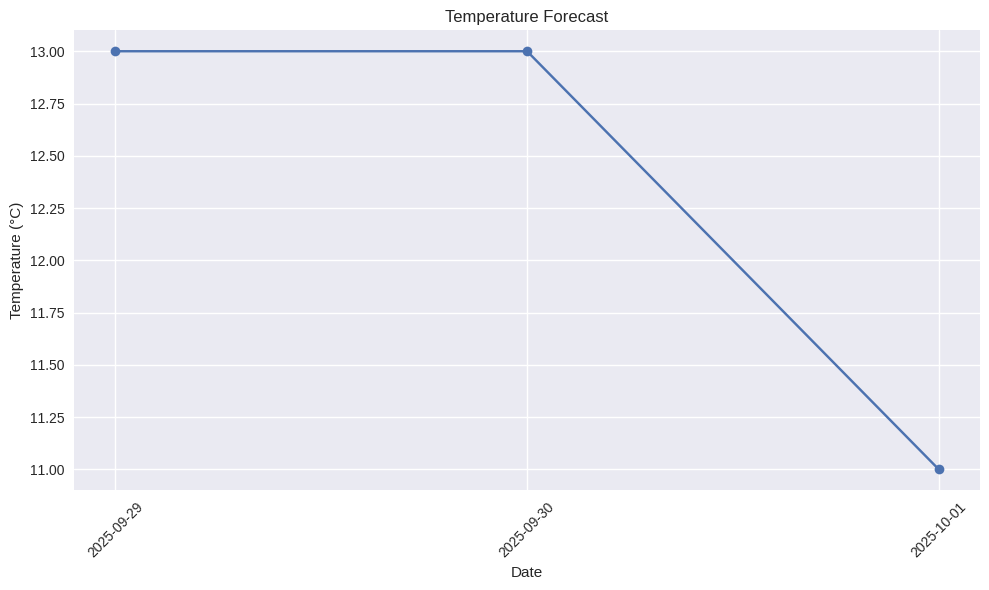

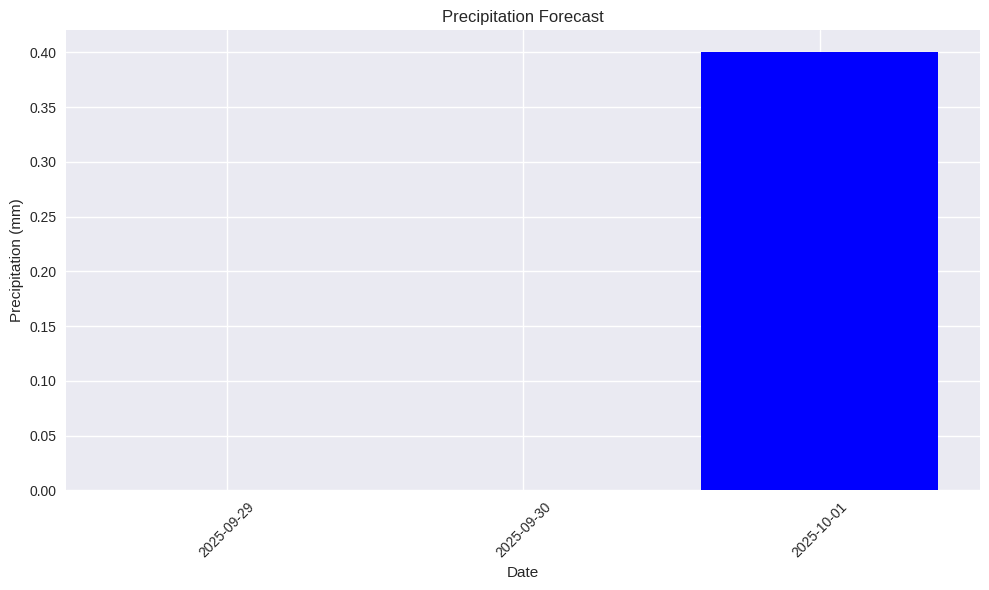

Expected precipitation in tomorrow in Paris is 0.0mm.


In [41]:
# Include sample input/output for each function

# Sample test
sample = get_weather_data('Melbourne')
create_temperature_visualisation(sample)
create_precipitation_visualisation(sample)
pq = parse_weather_question("Will it rain tomorrow in Paris?")
pdata = get_weather_data(pq['location'])
print(generate_weather_response(pq, pdata))


## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.